In [58]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from fibheap import FibonacciHeap as FibHeap
from peel_by_motif import *
from utils import *

import random, math, collections
import pandas as pd
from datetime import datetime
from compare_algs.greedy_algorithms import *
# import graph_tool.all as gt
from scipy.stats import entropy
plt.rcParams.update({'font.size': 14})

# read MIPS complex label for proteins

In [59]:
sgd_df = pd.read_csv('ppi/gold_standard/sgd.txt',delimiter='\t', names=['name','complex'])
name_to_comp = dict([(n, com) for n,com in sgd_df.values])

In [60]:
f = open('ppi/gold_standard/mips_3_100.txt', 'r')
mips_list = []
line = f.readline()
while line:
    mips_list.append(line.strip('\n').split(' '))
    line = f.readline()

# average number of proteins in one complex according to MIPS labels.

In [61]:
sum([len(m) for m in mips_list])/len(mips_list)

12.517241379310345

# Protein network 1: Collins. It does not have probs start with 1, 2, or 3

In [62]:
def summary(removed_nodes, G, node_mapping, mips_list):
    entropy_list = []
    for subgraph in removed_nodes:
        kro_mips = []
        sub_names = (get_key(node_mapping, subgraph))
        for name in sub_names:
            mip_idx = -1
            for i in range(len(mips_list)):
                if name in mips_list[i]:
                    mip_idx = i
            if mip_idx==-1:
                kro_mips.append(random.uniform(0,1))
            else:
                kro_mips.append(mip_idx)

        rates = nx.get_edge_attributes(G.subgraph(sub_names), "probability")
        value_list = list(rates.values())
        vs = plt.hist(value_list)
        plt.show()
        x = collections.Counter(kro_mips)
        freq_occ = np.array(list(x.values()))/sum(x.values())
        print(freq_occ)
        print('entropy according to mips complex:', entropy(freq_occ))
        entropy_list.append(entropy(freq_occ))
        print('end of this subgraph')
    return entropy_list, [len(sub) for sub in removed_nodes]

In [95]:
collin_df = pd.read_csv('ppi/collins2007.txt',delimiter='\t', names=['from','to','probability'])
col_G = nx.from_pandas_edgelist(collin_df, 'from', 'to', 'probability')

In [96]:
len(col_G.nodes), len(col_G.edges)

(1622, 9074)

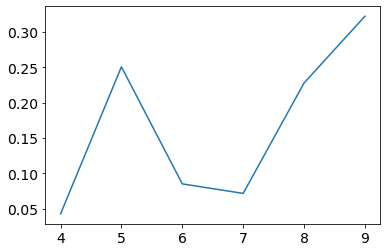

In [97]:
x = [get_start_digit(v) for v in collin_df['probability'].values]
x = collections.Counter(x)
num_occ = np.array([x[k] for k in range(4,10)])/sum([x[k] for k in range(4,10)])
plt.plot([i for i in range(4,10)], num_occ)

# Peeling heuristic with chi square statistics

In [98]:
nodes = set(collin_df['from']) | set(collin_df['to'])
node_mapping = {}
node_ind = 0
for node in nodes:
    node_mapping[node] = node_ind
    node_ind += 1
num_nodes = len(nodes)
edges = [(node_mapping[edge[0]], node_mapping[edge[1]], get_start_digit(edge[2])) for edge in collin_df.values]

In [99]:
node_chisquares = node_chisquare(edges, num_nodes, num_occ, adjust_idx=4)
_ = several_peel_weighted(edges, node_chisquares, peel_times=6, log=False)

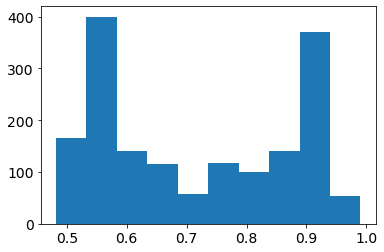

[0.62318841 0.33333333 0.01449275 0.01449275 0.01449275]
entropy according to mips complex: 0.8450054619712648
end of this subgraph


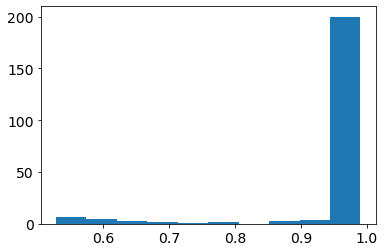

[0.77272727 0.04545455 0.04545455 0.04545455 0.04545455 0.04545455]
entropy according to mips complex: 0.9017412329512396
end of this subgraph


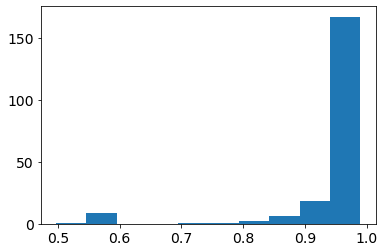

[0.85714286 0.04761905 0.04761905 0.04761905]
entropy according to mips complex: 0.5670609309552819
end of this subgraph


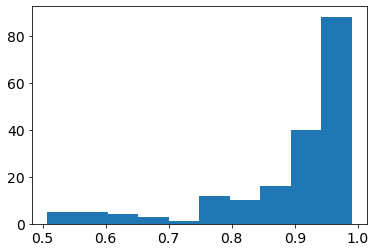

[0.95 0.05]
entropy according to mips complex: 0.1985152433458726
end of this subgraph


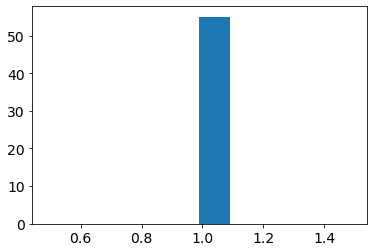

[1.]
entropy according to mips complex: 0.0
end of this subgraph


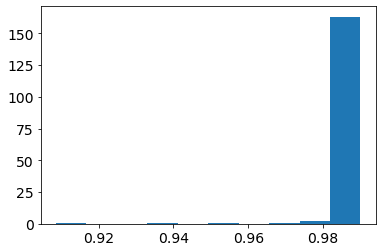

[0.22222222 0.25925926 0.03703704 0.07407407 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704 0.03703704
 0.03703704 0.03703704 0.03703704]
entropy according to mips complex: 2.3418286356385734
end of this subgraph


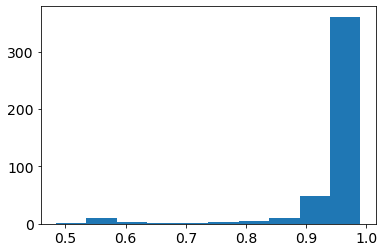

[0.01492537 0.1641791  0.23880597 0.10447761 0.05970149 0.01492537
 0.01492537 0.01492537 0.02985075 0.01492537 0.01492537 0.01492537
 0.04477612 0.10447761 0.01492537 0.01492537 0.01492537 0.01492537
 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537 0.01492537]
entropy according to mips complex: 2.589643092301462
end of this subgraph


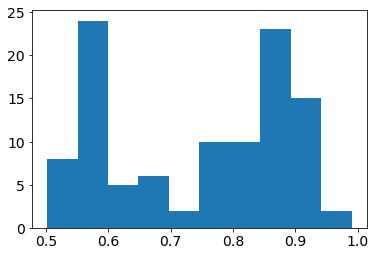

[0.9375 0.0625]
entropy according to mips complex: 0.2337916587064593
end of this subgraph


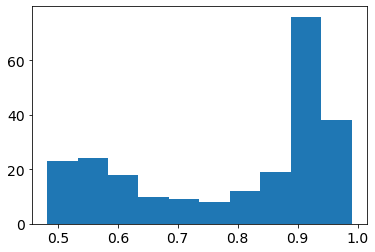

[0.03333333 0.03333333 0.03333333 0.06666667 0.03333333 0.13333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.06666667 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333]
entropy according to mips complex: 3.1239385094381773
end of this subgraph


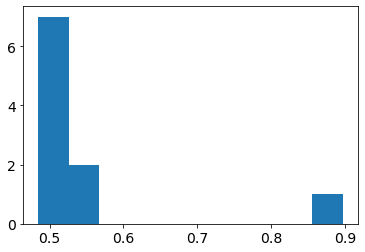

[0.5        0.16666667 0.16666667 0.16666667]
entropy according to mips complex: 1.2424533248940002
end of this subgraph


In [100]:

entropy_list_chi, size_list_chi = summary(_, col_G, node_mapping, mips_list)


In [101]:
sum(size_list_chi[:6])/6

28.333333333333332

# peel with probability as weight

In [102]:
pairs = [(node_mapping[edge[0]], node_mapping[edge[1]], edge[2]) for edge in collin_df.values]
removed_nodes = []
for i in range(6):
    node_d, fibheap = init_heap_dict_weighted(pairs)
    results = peel_by_edge(node_d, fibheap, pairs, 1, log=False, log_interval=10000)

    removed_nodes.append(results[1])

    new_pairs = []
    for pair in pairs:
        if pair[0] in results[1] or pair[1] in results[1]:
            continue
        else:
            new_pairs.append(pair)
    pairs = new_pairs

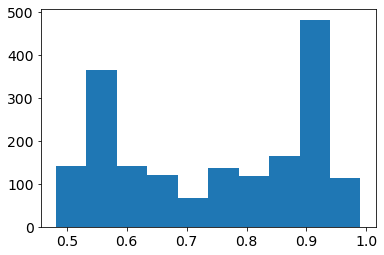

[0.62318841 0.34782609 0.01449275 0.01449275]
entropy according to mips complex: 0.7847601726672031
end of this subgraph


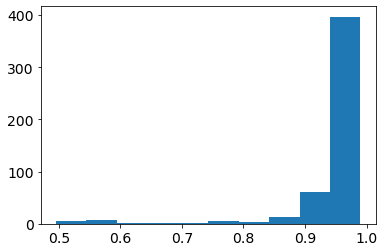

[0.06521739 0.39130435 0.41304348 0.02173913 0.02173913 0.02173913
 0.02173913 0.02173913 0.02173913]
entropy according to mips complex: 1.409796415786972
end of this subgraph


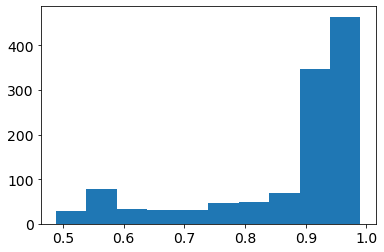

[0.00970874 0.00970874 0.22330097 0.00970874 0.00970874 0.00970874
 0.00970874 0.09708738 0.00970874 0.00970874 0.08737864 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.01941748 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874 0.00970874
 0.00970874 0.00970874 0.00970874]
entropy according to mips complex: 3.505568469264036
end of this subgraph


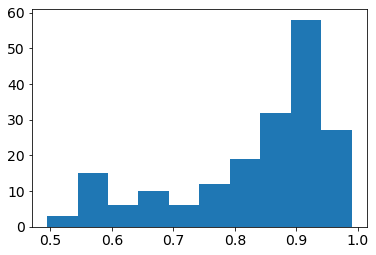

[0.95 0.05]
entropy according to mips complex: 0.1985152433458726
end of this subgraph


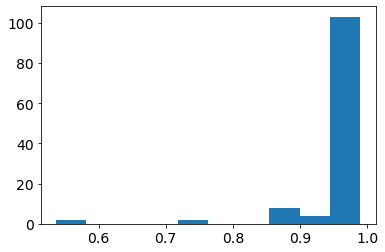

[0.4375 0.125  0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
entropy according to mips complex: 1.8346096344580887
end of this subgraph


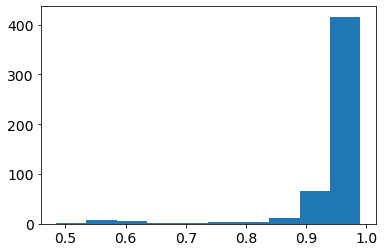

[0.08450704 0.15492958 0.22535211 0.11267606 0.1971831  0.01408451
 0.01408451 0.01408451 0.02816901 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451 0.01408451
 0.01408451 0.01408451]
entropy according to mips complex: 2.3407439097010467
end of this subgraph


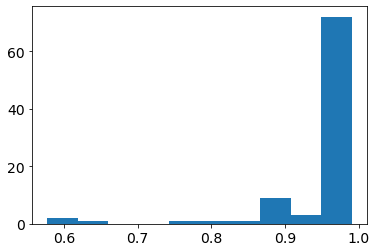

[0.07142857 0.07142857 0.07142857 0.5        0.07142857 0.07142857
 0.07142857 0.07142857]
entropy according to mips complex: 1.6661022550876021
end of this subgraph


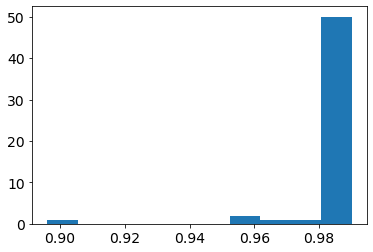

[0.09090909 0.45454545 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909]
entropy according to mips complex: 1.666332585328325
end of this subgraph


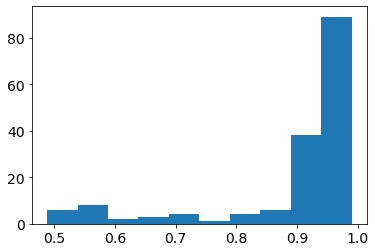

[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.06666667 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
entropy according to mips complex: 3.3549875696248255
end of this subgraph


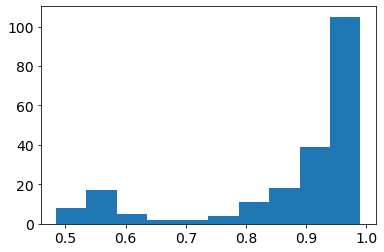

[0.02083333 0.02083333 0.29166667 0.14583333 0.02083333 0.02083333
 0.02083333 0.02083333 0.02083333 0.08333333 0.14583333 0.02083333
 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333 0.02083333
 0.02083333 0.02083333]
entropy according to mips complex: 2.41839429953565
end of this subgraph


In [103]:

entropy_list_weight, size_list_weight = summary(removed_nodes, col_G, node_mapping, mips_list)

# peel as unweighted graph

In [104]:
pairs = [(node_mapping[edge[0]], node_mapping[edge[1]], 1) for edge in collin_df.values]
removed_nodes = []
for i in range(6):
    node_d, fibheap = init_heap_dict_weighted(pairs)
    results = peel_by_edge(node_d, fibheap, pairs, 1, log=False, log_interval=10000)
#     print(results[1])
    removed_nodes.append(results[1])

    new_pairs = []
    for pair in pairs:
        if pair[0] in results[1] or pair[1] in results[1]:
            continue
        else:
            new_pairs.append(pair)
    pairs = new_pairs

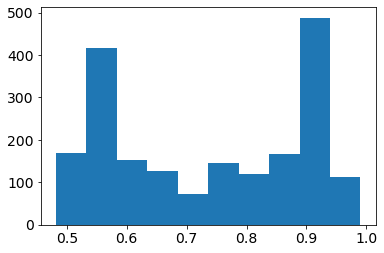

[0.61643836 0.32876712 0.01369863 0.01369863 0.01369863 0.01369863]
entropy according to mips complex: 0.8990470580248968
end of this subgraph


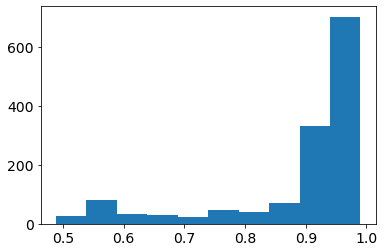

[0.00813008 0.02439024 0.00813008 0.14634146 0.19512195 0.00813008
 0.00813008 0.00813008 0.15447154 0.00813008 0.00813008 0.06504065
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008 0.00813008
 0.00813008 0.00813008]
entropy according to mips complex: 3.152219368591222
end of this subgraph


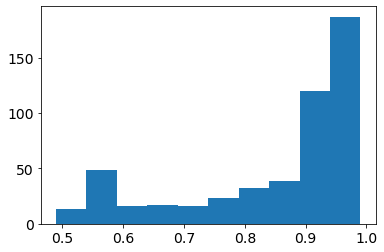

[0.42857143 0.02040816 0.02040816 0.2244898  0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816]
entropy according to mips complex: 2.048721947233607
end of this subgraph


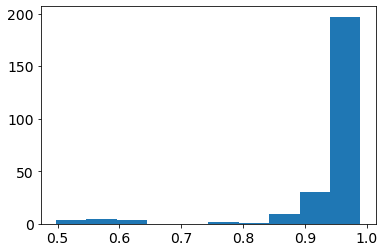

[0.48484848 0.21212121 0.06060606 0.03030303 0.03030303 0.03030303
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303]
entropy according to mips complex: 1.6974443808500084
end of this subgraph


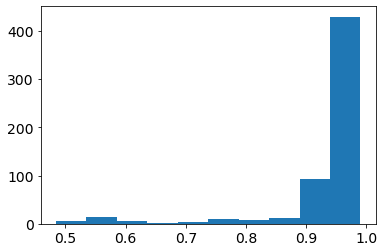

[0.01265823 0.07594937 0.13924051 0.01265823 0.08860759 0.10126582
 0.17721519 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.02531646 0.01265823 0.01265823 0.08860759 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823 0.01265823
 0.01265823]
entropy according to mips complex: 2.858830432060732
end of this subgraph


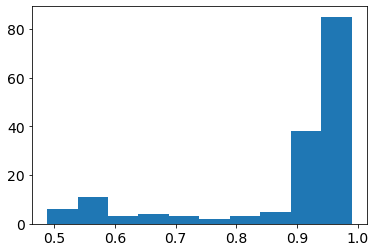

[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.06666667 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
entropy according to mips complex: 3.3549875696248255
end of this subgraph


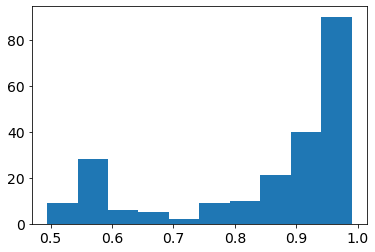

[0.02222222 0.22222222 0.02222222 0.26666667 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.08888889
 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222 0.02222222
 0.02222222 0.02222222 0.02222222 0.02222222]
entropy according to mips complex: 2.509108974839741
end of this subgraph


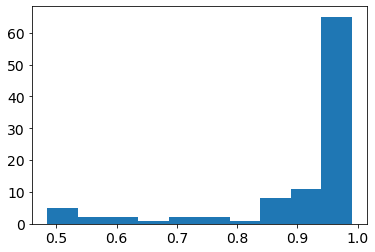

[0.04 0.6  0.28 0.04 0.04]
entropy according to mips complex: 1.049190862471387
end of this subgraph


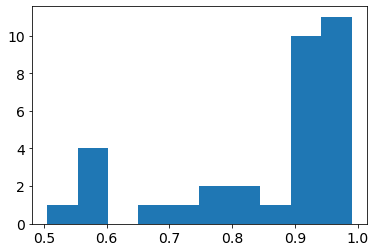

[0.11111111 0.44444444 0.11111111 0.22222222 0.11111111]
entropy according to mips complex: 1.4270610433807247
end of this subgraph


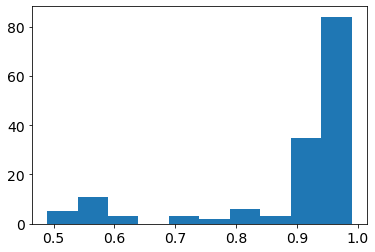

[0.14285714 0.14285714 0.02040816 0.10204082 0.12244898 0.14285714
 0.04081633 0.02040816 0.02040816 0.04081633 0.02040816 0.02040816
 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816 0.02040816
 0.02040816 0.02040816]
entropy according to mips complex: 2.6176478852547045
end of this subgraph


In [105]:
entropy_list_unweight, size_list_unweight = summary(removed_nodes, col_G, node_mapping, mips_list)

# Collins PPI network, entropy of subgraph based on MIPS complex label of each node

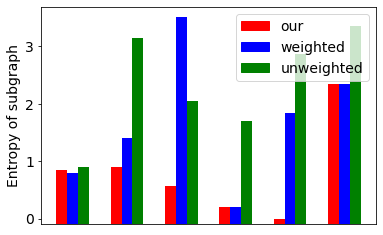

In [106]:
x = [i*1.5 for i in range(6)]
plt.bar(np.array(x)-0.45, np.array(entropy_list_chi[:6])+0.1, width = 0.3, color='r')
plt.bar(np.array(x)-0.15, np.array(entropy_list_weight[:6])+0.1, width = 0.3, color='b')
plt.bar(np.array(x)+0.15, np.array(entropy_list_unweight[:6])+0.1, width = 0.3, color='g')
#setting the xticks. Note x1 and x2 are tuples, thus + is concatenation
plt.xticks([]) 
plt.yticks([0.1, 1.1, 2.1, 3.1], [0, 1, 2, 3]) 
# plt.ylim(bottom=-0.1)
plt.ylabel('Entropy of subgraph')
colors = {'our':'red', 'weighted':'blue', 'unweighted':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig('figs/ppi/collins_bar.png')
plt.show()

# Protein network 2: Gavin, probs start from digit 4

In [82]:
gavin_df = pd.read_csv('ppi/gavin2006_socioaffinities_rescaled.txt',delimiter=' ', names=['from','to','probability'])
gavin_G = nx.from_pandas_edgelist(gavin_df, 'from', 'to', 'probability')
# gavin_df

In [83]:
len(gavin_G.nodes), len(gavin_G.edges)

(1855, 7669)

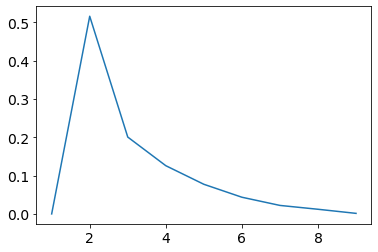

In [84]:
x = [get_start_digit(v) for v in gavin_df['probability'].values]
x = collections.Counter(x)
num_occ = np.array([x[k] for k in range(1,10)])/sum([x[k] for k in range(1,10)])
plt.plot([i for i in range(1,10)], num_occ)

In [85]:
nodes = set(gavin_df['from']) | set(gavin_df['to'])
node_mapping = {}
node_ind = 0
for node in nodes:
    node_mapping[node] = node_ind
    node_ind += 1
num_nodes = len(nodes)
edges = [(node_mapping[edge[0]], node_mapping[edge[1]], get_start_digit(edge[2])) for edge in gavin_df.values]

In [86]:
node_chisquares = node_chisquare(edges, num_nodes, num_occ, adjust_idx=1)
_ = several_peel_weighted(edges, node_chisquares, peel_times=6, log=False)

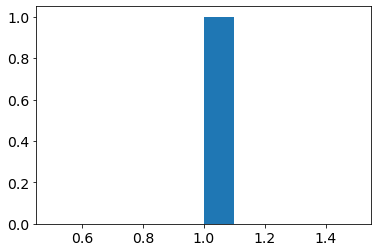

[0.5 0.5]
entropy according to mips complex: 0.6931471805599453
end of this subgraph


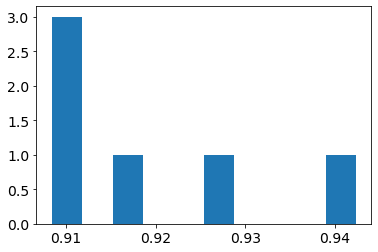

[0.5 0.5]
entropy according to mips complex: 0.6931471805599453
end of this subgraph


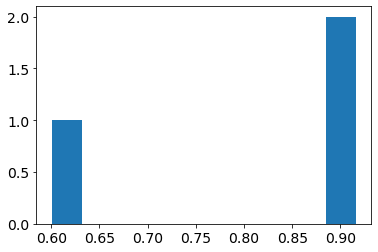

[0.33333333 0.33333333 0.33333333]
entropy according to mips complex: 1.0986122886681096
end of this subgraph


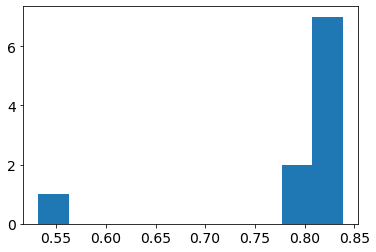

[0.8 0.2]
entropy according to mips complex: 0.5004024235381879
end of this subgraph


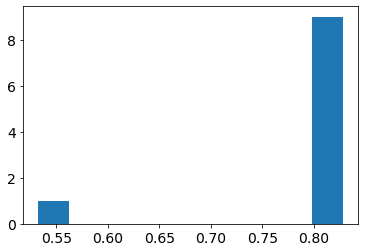

[1.]
entropy according to mips complex: 0.0
end of this subgraph


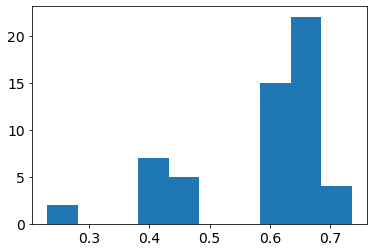

[0.09090909 0.09090909 0.63636364 0.09090909 0.09090909]
entropy according to mips complex: 1.159588814308626
end of this subgraph


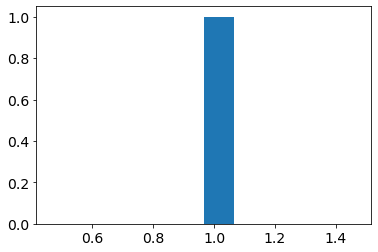

[1.]
entropy according to mips complex: 0.0
end of this subgraph


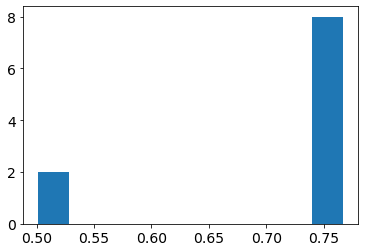

[0.8 0.2]
entropy according to mips complex: 0.5004024235381879
end of this subgraph


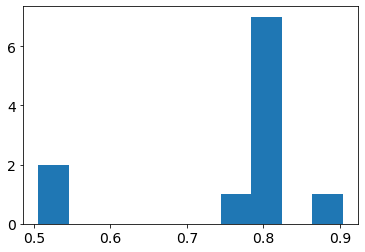

[0.57142857 0.28571429 0.14285714]
entropy according to mips complex: 0.9556998911125343
end of this subgraph


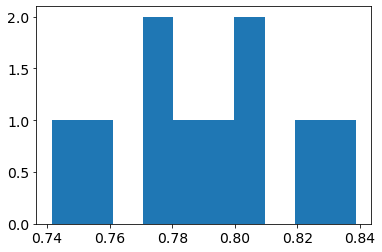

[1.]
entropy according to mips complex: 0.0
end of this subgraph


In [87]:
entropy_list_chi, size_list_chi = summary(_, gavin_G, node_mapping, mips_list)

In [88]:
sum(size_list_chi[:6])/6

5.333333333333333

In [89]:
pairs = [(node_mapping[edge[0]], node_mapping[edge[1]], edge[2]) for edge in gavin_df.values]
removed_nodes = []
for i in range(6):
    node_d, fibheap = init_heap_dict_weighted(pairs)
    results = peel_by_edge(node_d, fibheap, pairs, 1, log=False, log_interval=10000)

#     print(results[1])
    removed_nodes.append(results[1])

    new_pairs = []
    for pair in pairs:
        if pair[0] in results[1] or pair[1] in results[1]:
            continue
        else:
            new_pairs.append(pair)
    pairs = new_pairs

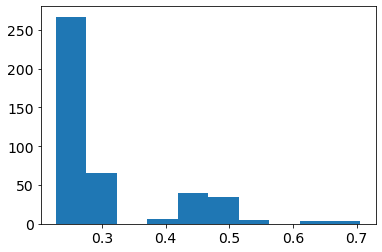

[0.9        0.03333333 0.03333333 0.03333333]
entropy according to mips complex: 0.4349442022582592
end of this subgraph


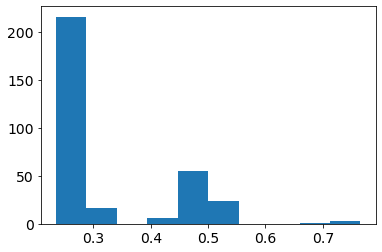

[0.92307692 0.03846154 0.03846154]
entropy according to mips complex: 0.32450838693107065
end of this subgraph


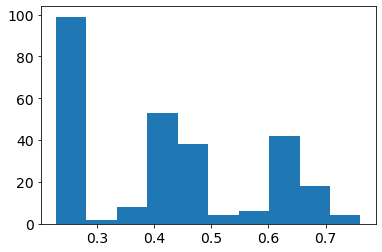

[0.02941176 0.11764706 0.5        0.02941176 0.02941176 0.20588235
 0.02941176 0.02941176 0.02941176]
entropy according to mips complex: 1.546031838239031
end of this subgraph


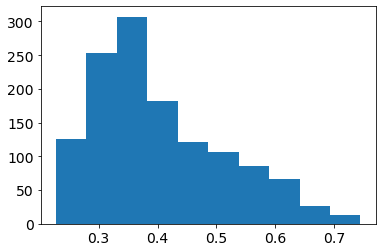

[0.00595238 0.08928571 0.00595238 0.00595238 0.00595238 0.17261905
 0.04166667 0.00595238 0.00595238 0.13095238 0.00595238 0.00595238
 0.00595238 0.00595238 0.05357143 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.01785714 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238
 0.00595238 0.00595238 0.00595238 0.00595238 0.00595238]
entro

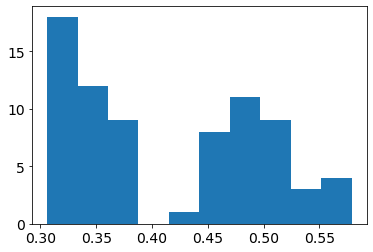

[0.46153846 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 0.07692308 0.07692308]
entropy according to mips complex: 1.73798344858705
end of this subgraph


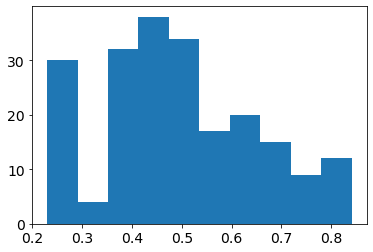

[0.22727273 0.15909091 0.11363636 0.02272727 0.04545455 0.04545455
 0.02272727 0.02272727 0.09090909 0.02272727 0.04545455 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727]
entropy according to mips complex: 2.547860723387867
end of this subgraph


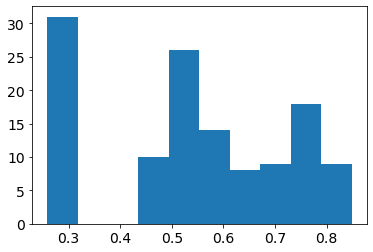

[0.16216216 0.13513514 0.18918919 0.18918919 0.27027027 0.02702703
 0.02702703]
entropy according to mips complex: 1.744260091177909
end of this subgraph


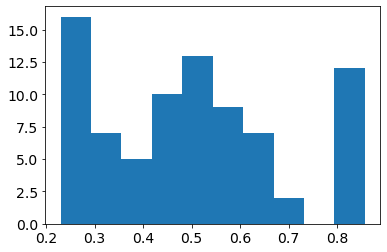

[0.39130435 0.04347826 0.34782609 0.2173913 ]
entropy according to mips complex: 1.2025488641189253
end of this subgraph


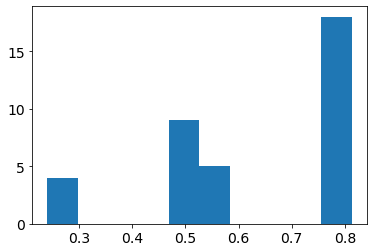

[0.07692308 0.07692308 0.30769231 0.07692308 0.15384615 0.07692308
 0.07692308 0.07692308 0.07692308]
entropy according to mips complex: 2.031759218569271
end of this subgraph


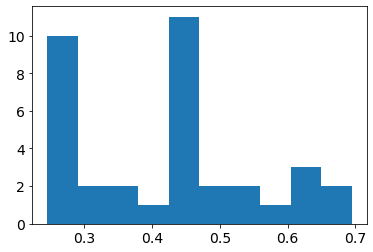

[0.11111111 0.11111111 0.11111111 0.11111111 0.11111111 0.11111111
 0.11111111 0.11111111 0.11111111]
entropy according to mips complex: 2.1972245773362196
end of this subgraph


In [90]:
entropy_list_weight, size_list_weight = summary(removed_nodes, gavin_G, node_mapping, mips_list)

In [91]:
pairs = [(node_mapping[edge[0]], node_mapping[edge[1]], 1) for edge in gavin_df.values]
removed_nodes = []
for i in range(6):
    node_d, fibheap = init_heap_dict_weighted(pairs)
    results = peel_by_edge(node_d, fibheap, pairs, 1, log=False, log_interval=10000)
#     print(results[1])
    removed_nodes.append(results[1])

    new_pairs = []
    for pair in pairs:
        if pair[0] in results[1] or pair[1] in results[1]:
            continue
        else:
            new_pairs.append(pair)
    pairs = new_pairs

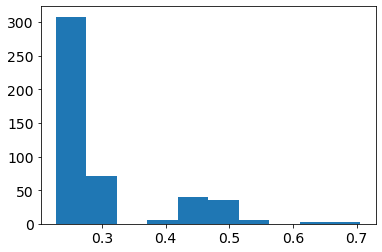

[0.875   0.03125 0.03125 0.03125 0.03125]
entropy according to mips complex: 0.5500569563964232
end of this subgraph


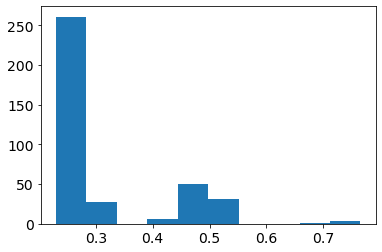

[0.82758621 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]
entropy according to mips complex: 0.7371823152157603
end of this subgraph


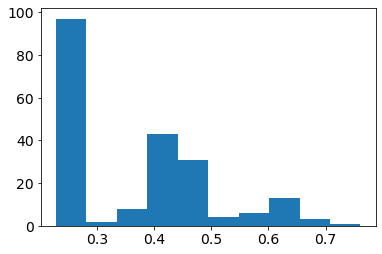

[0.18181818 0.77272727 0.04545455]
entropy according to mips complex: 0.6496877127476234
end of this subgraph


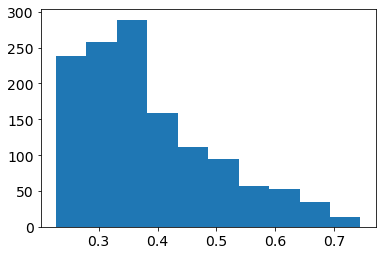

[0.00628931 0.00628931 0.00628931 0.00628931 0.01257862 0.00628931
 0.17610063 0.00628931 0.00628931 0.14465409 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.05660377 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.01257862 0.00628931 0.04402516 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931
 0.00628931 0.00628931 0.00628931 0.00628931 0.00628931 0.0062

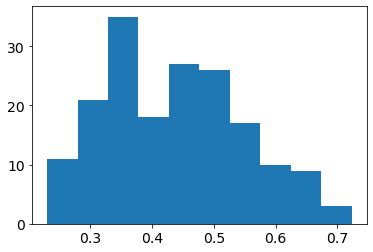

[0.24137931 0.48275862 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276]
entropy according to mips complex: 1.6235657038485152
end of this subgraph


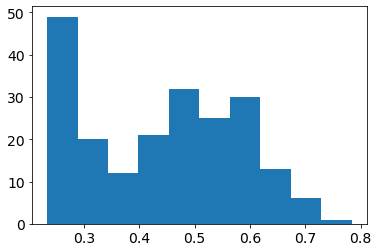

[0.21052632 0.18421053 0.02631579 0.26315789 0.02631579 0.05263158
 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579 0.02631579
 0.02631579 0.02631579 0.02631579]
entropy according to mips complex: 2.1989269842556958
end of this subgraph


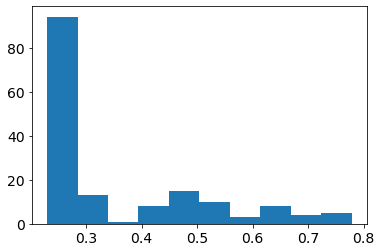

[0.14705882 0.05882353 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.05882353 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176 0.02941176
 0.02941176 0.02941176 0.02941176 0.02941176]
entropy according to mips complex: 3.2081317515452716
end of this subgraph


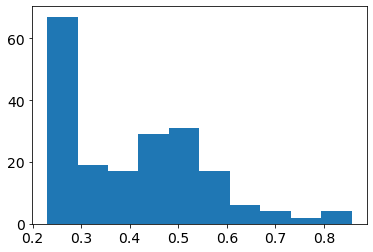

[0.20454545 0.02272727 0.20454545 0.02272727 0.11363636 0.02272727
 0.02272727 0.02272727 0.04545455 0.02272727 0.02272727 0.04545455
 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727 0.02272727
 0.02272727 0.02272727 0.02272727 0.02272727]
entropy according to mips complex: 2.639420982180485
end of this subgraph


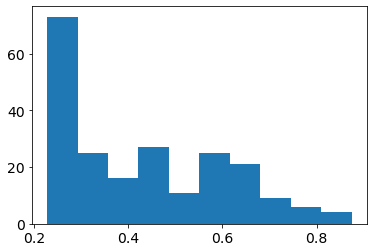

[0.01724138 0.01724138 0.01724138 0.01724138 0.25862069 0.01724138
 0.13793103 0.12068966 0.12068966 0.01724138 0.01724138 0.06896552
 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138 0.01724138
 0.01724138 0.01724138 0.01724138 0.01724138]
entropy according to mips complex: 2.5079567194908012
end of this subgraph


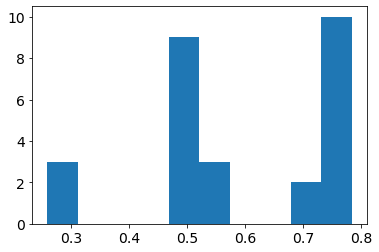

[0.875 0.125]
entropy according to mips complex: 0.37677016125643675
end of this subgraph


In [92]:
entropy_list_unweight, size_list_unweight = summary(removed_nodes, gavin_G, node_mapping, mips_list)

# Gavin PPI network, entropy of subgraph based on MIPS complex label of each node

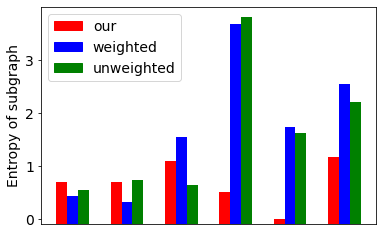

In [94]:
x = [i*1.5 for i in range(6)]
plt.bar(np.array(x)-0.45, np.array(entropy_list_chi[:6])+0.1, width = 0.3, color='r')
plt.bar(np.array(x)-0.15, np.array(entropy_list_weight[:6])+0.1, width = 0.3, color='b')
plt.bar(np.array(x)+0.15, np.array(entropy_list_unweight[:6])+0.1, width = 0.3, color='g')
#setting the xticks. Note x1 and x2 are tuples, thus + is concatenation
plt.xticks([]) 
plt.yticks([0.1, 1.1, 2.1, 3.1], [0, 1, 2, 3]) 
# plt.ylim(bottom=-0.1)
plt.ylabel('Entropy of subgraph')
colors = {'our':'red', 'weighted':'blue', 'unweighted':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.savefig('figs/ppi/gavin_bar.png')
plt.show()